# TF.IDF Model

In [9]:
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data

In [11]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=1) 

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)
df

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bete
filename,,,,,,,
ECLI_NL_RBGEL_2018_50.xml,3,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,2018-01-08,[][' tenlastelegging aan verdachte is ten la...
ECLI_NL_GHAMS_2019_194.xml,4,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,2019-01-25,[' het bewijs tegen de verdachte de kern...
ECLI_NL_RBOVE_2021_606.xml,7,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),2021-02-10,"[][' tenlastelegging de verdenking komt er, ..."
ECLI_NL_GHSHE_2021_1801.xml,8,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,[' bewijsmiddelen indien tegen dit ve...
ECLI_NL_GHARL_2020_820.xml,9,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[' bewijsmiddelen, feiten en omstandighed..."
...,...,...,...,...,...,...,...
ECLI_NL_RBNHO_2021_1491.xml,2902,ECLI:NL:RBNHO:2021:1491,Strafrecht,Haarlem,15/246961-19,2021-02-25,[][' 1tenlastelegging aan verdachte is ten l...
ECLI_NL_RBGEL_2019_7.xml,2906,ECLI:NL:RBGEL:2019:7,Strafrecht,Arnhem,"05/880261-18, 05/720119-18 en 05/840018-18",2019-01-02,[][' bijlage: tenl...
ECLI_NL_GHARL_2021_1849.xml,2907,ECLI:NL:GHARL:2021:1849,Strafrecht,Leeuwarden,21-002353-20,2021-02-26,[' bewijsmiddel 3: het hof voegt aan het ...


# Tokenize 

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['bete']))

print(data_words[:1])

[['tenlastelegging', 'aan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'hij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf', 'jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', '

# Creating Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['tenlastelegging', 'aan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'hij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf_jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', 'met'

# Remove Stopwords, Make Bigrams and Lemmatize

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tenlastelegging', 'verdenken', 'last', 'leggen', 'periode', 'oostenrijk', 'opzettelijk', 'minderjarig', 'weten', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'onttrekken', 'wettig', 'stellen', 'gezag', 'opzicht', 'desbevoegd', 'uitoefenen', 'minderjarig', 'twaalf_jar', 'oud', 'list', 'bezigen', 'bestaan', 'verdenken', 'school', 'minderjarig', 'strijd', 'waarheid', 'mededeel', 'minderjarig', 'afspraak', 'tandarts', 'minderjarig', 'daarvoor', 'vroeger', 'halen', 'school', 'verdenken', 'huis', 'lok', 'verdachte', 'echtgenote', 'genaamd', 'naam', 'maken', 'afspraak', 'woonboulevard', 'beweerdelijk', 'gaan', 'shopp', 'verdenken', 'paspoort', 'kleding', 'toiletartikel', 'minderjarig', 'woning', 'toverweging', 'aanzien', 'bewijs', 'feit', 'grond', 'bewijsmiddel', 'volgen', 'ver', 'discussie', 'staan', 'vaststellen', 'aangeefster', 'naam', 'verdenken', 'trouwen', 'samen', 'kind', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', '

#  Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
corpus = [str (item) for item in corpus]

# View
print(corpus[:1])

['[(0, 6), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 5), (34, 4), (35, 4), (36, 1), (37, 2), (38, 3), (39, 1), (40, 4), (41, 1), (42, 1), (43, 1), (44, 2), (45, 10), (46, 2), (47, 1), (48, 3), (49, 3), (50, 3), (51, 3), (52, 2), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 6), (60, 1), (61, 10), (62, 4), (63, 1), (64, 1), (65, 3), (66, 2), (67, 2), (68, 2), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 4), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 3), (91, 1), (92, 3), (93, 1), (94, 4), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 1), (108, 1), (109, 3), (110,

In [17]:
# Id word
id2word[0]

'aangeefster'

# Building the Topic Model T-SNE

In [18]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
num_clusters = 5
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [21]:
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
)

In [22]:
labels = clustering_model.fit_predict(X)
X = X.todense()

In [23]:
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

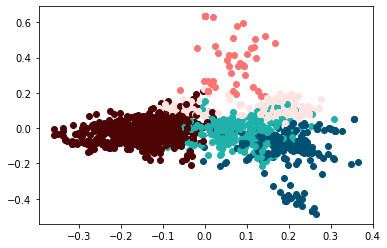

In [24]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

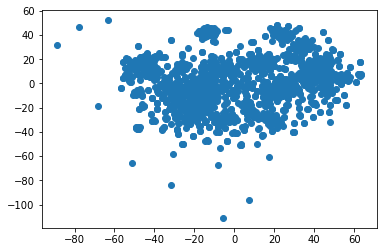

In [25]:
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

In [26]:
from gensim.models import word2vec
model = word2vec.Word2Vec(corpus, window=20, min_count=500, workers=4)

# Another Approach 

In [67]:
model = word2vec.Word2Vec(data_lemmatized, window=20, min_count=200, workers=4)
model.wv['tenlastelegging']

array([-3.2506778 , -1.9187467 , -3.9900513 ,  3.11021   , -1.5007925 ,
        3.919185  ,  3.5659885 , -3.2963967 , -0.86580735,  0.7071569 ,
        0.2352274 ,  1.2812591 ,  1.6703801 ,  1.4473207 , -1.3482465 ,
       -2.575852  , -0.22016533, -1.9163706 , -2.393368  ,  0.7855979 ,
        0.07975458, -1.0133209 ,  1.091605  , -2.0494905 ,  0.2589173 ,
        0.38227302, -0.66564405, -3.9536755 , -4.198935  ,  0.8224755 ,
        1.411243  , -1.2495157 , -2.782421  , -0.77150786, -1.2831271 ,
        1.5309086 , -4.286497  ,  1.948101  ,  2.8848748 , -2.7601507 ,
       -1.1929556 ,  1.4370842 , -0.97230995,  0.9982619 , -2.194997  ,
        0.64070433, -0.80722094, -1.7557293 ,  1.0128754 ,  1.835027  ,
        1.5870917 ,  0.531539  ,  2.6852746 , -1.4193265 ,  1.3777874 ,
        1.8966703 ,  0.06109388,  2.4527612 , -2.182652  , -2.8111382 ,
        0.9681095 ,  2.9013333 , -0.0738583 , -1.4207765 ,  1.6939452 ,
        0.45051143, -3.2402084 , -1.2158464 ,  0.56682247, -3.53

In [83]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

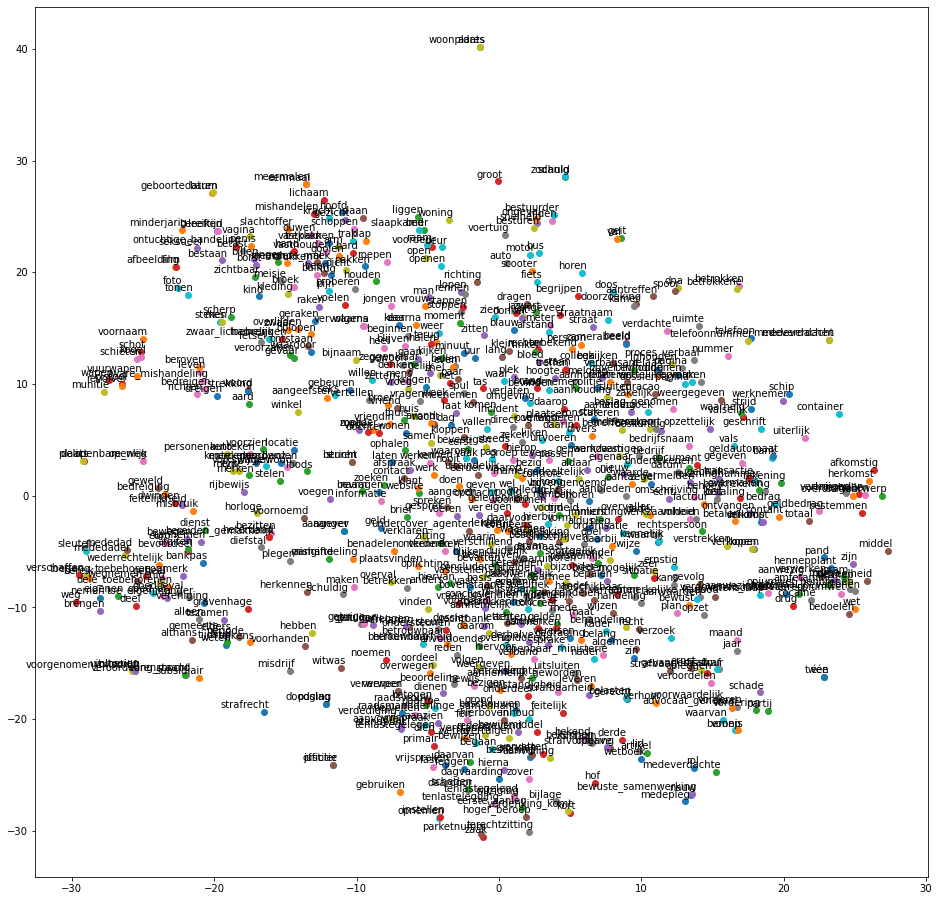

In [84]:
tsne_plot(model)

In [82]:
q = 0
for word in model.wv.key_to_index:
    q += 1
    print(model.wv.key_to_index[word])
    if q == 10:
        break

0
1
2
3
4
5
6
7
8
9


True

In [ ]:

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4